In [1]:
from torchvision import transforms
from torchvision.models import *
import matplotlib.pyplot as plt
import torchvision.models as models
from torchvision import transforms
import numpy as np
import torch
from torch.utils.data import DataLoader
import torch.optim as optim
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
import torchvision
import wandb
import os
import warnings
import torch.nn as nn
#from torchsummary import summary
from torch.distributions import Normal, Independent, kl, MultivariateNormal
from typing import Optional, List
from torch import Tensor
import math
import time
from Variational_transformer import *
from cityscapesscripts.helpers.labels import labels as city_labels
from torchvision.datasets import Cityscapes
from Transformer import *
from VAE import *
from PIL import Image, ImageDraw
import glob
import json
import re
from torchvision import transforms
from dataloader_cityscapes import *
import random
import torchvision.transforms.functional as TF
device = torch.device("cuda:0")
%matplotlib inline
warnings.filterwarnings("ignore")

## Cityscapes API dataloader

In [24]:
dataset = Cityscapes('../datasets/Cityscapes/', split='train', mode='fine', target_type='semantic')
len(dataset)

2975

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([34, 256, 256])
torch.Size([3, 256, 256])


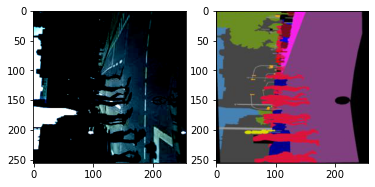

In [12]:
preprocess_in = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.Resize((256,256))
])

preprocess_ou = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256,256))
])

tr_loader = CityscapesLoader("../datasets/augmented_cityscapes", transform_in = preprocess_in, transform_ou = preprocess_ou)
train_loader = DataLoader(dataset = tr_loader, batch_size = 50, shuffle = True)



for i in train_loader:
    print(i["label"][0].shape)
    print(i["seg"][0].shape)
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(i["image"][0].permute(2,1,0))
    axarr[1].imshow(i["seg"][0].permute(2,1,0))
    break

In [65]:
preprocess_in = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.Resize((256,256))
])

preprocess_ou = transforms.Compose([
    transforms.Resize((256,256))
])

tr_loader = CityscapesLoader("../datasets/augmented_cityscapes", transform_in = preprocess_in)
train_loader = DataLoader(dataset = tr_loader, batch_size = 50, shuffle = True)



for batch in train_loader:
    for i in range(len(batch["image"])):
        if list(batch["image"][i].shape) != [3,256,256]:
            print(batch["image"][i].shape)
            print("error!")
        
#     f, axarr = plt.subplots(1,2)
#     axarr[0].imshow(i["image"][0].permute(2,1,0))
#     axarr[1].imshow(i["seg"][0].permute(2,1,0))

In [69]:
x = torch.rand((128,128,3))
if list(x.shape) != [128,128,3]:
    print("hello")

## Transformer model time measure

In [20]:
batch_size = 128
dim = 256
input_image = torch.randn(batch_size, 3, dim, dim)
input_seg = torch.randn(batch_size, 3, dim, dim)

In [21]:
VT = VariationalTransformer(**{"input_img_dim":[dim,dim], "transformer_emb_dim":256, "transformer_num_heads":2,
                       "transformer_num_encoder_layer": 1, "transformer_num_dec_layer": 1, 
                       "transformer_intermediate_layer_dim": 512, "transformer_dropout_per":0,
                       "prior_input_channels":3, "prior_posterior_layers":[64,128,256],
                       "posterior_input_channels":6, "batch_size":batch_size,
                        "num_cat":35})

Using cache found in /home/lunet/wsmo6/.cache/torch/hub/pytorch_vision_v0.10.0


In [22]:
start = time.time()
out = VT(input_image, input_seg)
end = time.time()
print(end - start)

torch.Size([128, 256])
torch.Size([128, 1, 16, 16])
16.974445104599


In [ ]:
start = time.time()
for i in VT.inference(torch.randn(1, 3, 256, 256)):
    print(i.shape)
end = time.time()
print(end - start)

## My own dataloader

In [17]:
def find_color(label):
    for i in range(len(city_labels)):
        if label == city_labels[i].name:
            return list(city_labels[i].color)

In [18]:
def generate_prob_mask(img, seg_mask, json_obj, label_to_id, num_classes = 35):
    
    segments = []
    prob_mask = np.zeros((img.shape[0], img.shape[1], num_classes))
    
    for label in json_obj['objects']:
        label = label['label']
        if "group" in label:
            label = re.sub("group", "", label)
        color = find_color(label)
        color.append(255)
        mask = (seg_mask == color).all(-1)
        tmp = np.zeros((num_classes))
        tmp[label_to_id[label]] = 1
        prob_mask[mask] = tmp
        
    return prob_mask

../datasets/Cityscapes/leftImg8bit/train/weimar/weimar_000083_000019_leftImg8bit.png
../datasets/Cityscapes/gtFine/train/weimar/weimar_000083_000019_gtFine_color.png
../datasets/Cityscapes/gtFine/train/weimar/weimar_000083_000019_gtFine_polygons.json
../datasets/Cityscapes/gtFine/train/weimar/weimar_000083_000019_gtFine_prob_mask.
1.6741809844970703


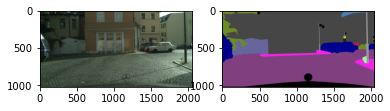

In [19]:
start = time.time()

mode = 'train'
add = "../datasets/Cityscapes/leftImg8bit/{}/*".format(mode)
label_to_id = {label.name:i for i,label in enumerate(city_labels)}
for folder in glob.iglob(add):
    for file in glob.iglob(os.path.join(folder,"*")):
        
        img_add = file
        gtFine = img_add.replace("leftImg8bit", "gtFine_color")
        gtFine = gtFine.replace("gtFine_color", "gtFine", 1)
        json_add = gtFine.replace("color", "polygons")
        json_add = json_add.replace("png", "json")
        
        img = np.array(Image.open(img_add))
        seg_mask = np.array(Image.open(gtFine))
        json_obj = json.load(open(json_add))
        
        label = generate_prob_mask(img, seg_mask, json_obj, label_to_id)
        label_add = gtFine.replace("gtFine_color", "gtFine_prob_mask")
        label_add = label_add.replace("png", "")
        np.save(label_add, label)
        
        f, axarr = plt.subplots(1,2)
        axarr[0].imshow(img)
        axarr[1].imshow(seg_mask)
        print(img_add)
        print(gtFine)
        print(json_add)
        print(label_add)
        
        
        
        break
    break
    
end = time.time()
print(end - start)

## Train loop

In [2]:
VT = VariationalTransformer(**{"input_img_dim":[256,256], "transformer_emb_dim":256, "transformer_num_heads":2,
                       "transformer_num_encoder_layer": 1, "transformer_num_dec_layer": 1, 
                       "transformer_intermediate_layer_dim": 512, "transformer_dropout_per":0,
                       "prior_input_channels":3, "prior_posterior_layers":[64,128,256],
                       "posterior_input_channels":37, "prior_posterior_layers":[64,128,256], "batch_size":50})

Using cache found in /home/lunet/wsmo6/.cache/torch/hub/pytorch_vision_v0.10.0


In [3]:
preprocess_in = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

preprocess_ou = transforms.Compose([
    transforms.ToTensor(),
])


tr_loader = CityscapesLoader("../datasets/augmented_cityscapes", transform_in = preprocess_in, transform_ou = preprocess_ou)
train_loader = DataLoader(dataset = tr_loader, batch_size = 50, shuffle = True)

In [4]:
for batch in train_loader:
    out = VT(batch["image"].float(), batch["label"])
    break

torch.Size([50, 256, 256])
torch.Size([50, 256, 256])
torch.Size([50, 256, 256])
torch.Size([50, 256, 256])
torch.Size([50, 256, 256])
torch.Size([50, 256, 256])
torch.Size([50, 256, 256])
torch.Size([50, 256, 256])
torch.Size([50, 256, 256])
torch.Size([50, 256, 256])
torch.Size([50, 256, 256])
torch.Size([50, 256, 256])
torch.Size([50, 256, 256])
torch.Size([50, 256, 256])
torch.Size([50, 256, 256])
torch.Size([50, 256, 256])


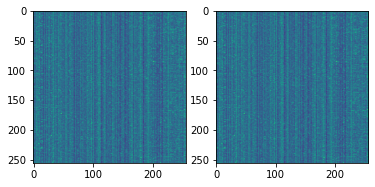

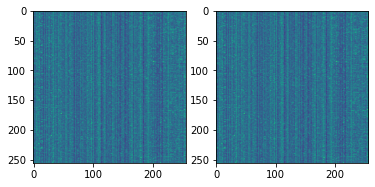

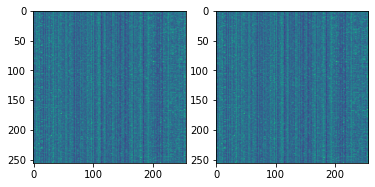

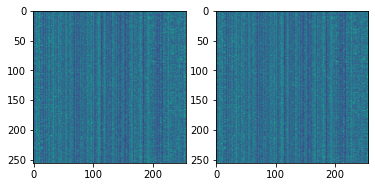

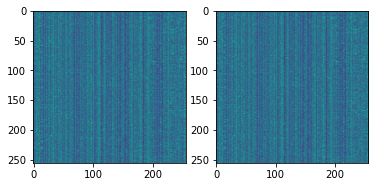

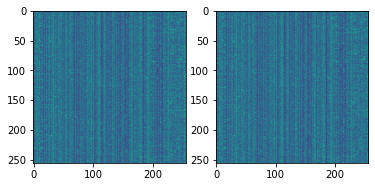

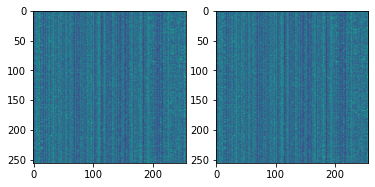

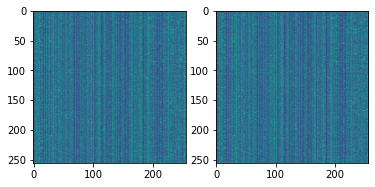

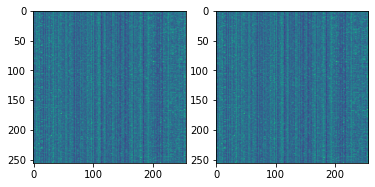

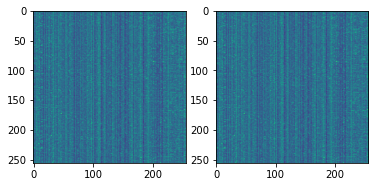

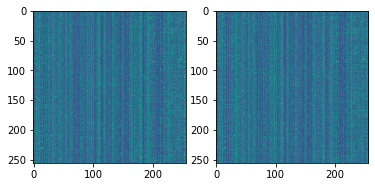

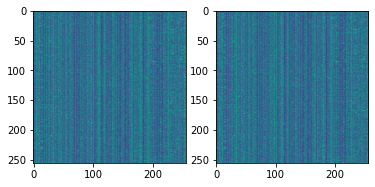

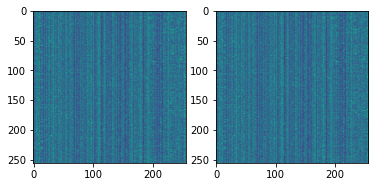

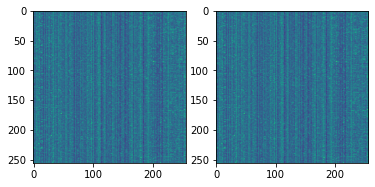

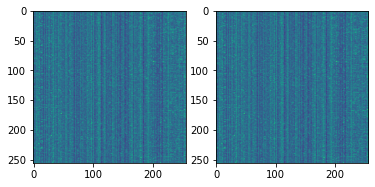

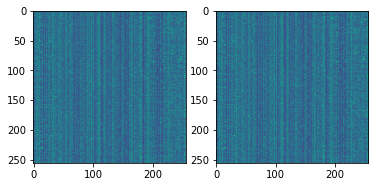

In [10]:
for batch in train_loader:
    for sample in VT.inference(batch["image"]):
        f, axarr = plt.subplots(1,2)
        axarr[0].imshow(sample[0].detach().numpy())
        axarr[1].imshow(sample[0].detach().numpy())
        print(sample.shape)
    break